# Direct Outcome Prediction Model
Also known as standardization

In [1]:
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from causallib.datasets import load_nhefs
from causallib.estimation import Standardization, StratifiedStandardization
from causallib.evaluation import evaluate

#### Data:
The effect of smoking cessation on weight loss.  
Data example is taken from [Hernan and Robins Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

In [2]:
data = load_nhefs()
data.X.join(data.a).join(data.y).head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,qsmk,wt82_71
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841,0,-10.093960
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576,0,2.604970
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676,0,9.414486
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809,0,4.990117
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361,0,4.989251


## "Standard" Standardization (S-Learner)
A single model (the *S* in S-Learner) is trained with the treatment assignment as an additional feature.  
During inference, the model assigns a single treatment value for all samples, thus predicting the potential outcome of all samples.

In [3]:
std = Standardization(LinearRegression())
std.fit(data.X, data.a, data.y)

Standardization(encode_treatment=False, predict_proba=False,
                learner=LinearRegression())

##### Outcome Prediction
The model can be used to predict individual outcomes:  
The potential outcome under each intervention (columns correspond to treatment values)

In [4]:
ind_outcomes = std.estimate_individual_outcome(data.X, data.a)
ind_outcomes.head()

qsmk,0,1
0,4.271756,7.734378
1,6.337239,9.799861
2,1.989807,5.452429
3,-4.261624,-0.799002
4,2.290883,5.753505


The model can be used to predict population outcomes,  
By aggregating the individual outcome prediction (e.g., mean or median).  
Providing `agg_func` which is defaulted to `'mean'`

In [5]:
median_pop_outcomes = std.estimate_population_outcome(data.X, data.a, agg_func="median")
median_pop_outcomes.rename("median", inplace=True)

mean_pop_outcomes = std.estimate_population_outcome(data.X, data.a, agg_func="mean")
mean_pop_outcomes.rename("mean", inplace=True)

pop_outcomes = mean_pop_outcomes.to_frame().join(median_pop_outcomes)
pop_outcomes

,mean,median
qsmk,,
0,1.747216,2.391416
1,5.209838,5.854038


##### Effect Estimation
Similarly, Effect estimation can be done on either individual or population level, depending on the outcomes provided.

Population level effect using population outcomes:

In [6]:
std.estimate_effect(mean_pop_outcomes[1], mean_pop_outcomes[0])

diff    3.462622
dtype: float64

Population level effect using individual outcome, but asking for aggregation (default behaviour):

In [7]:
std.estimate_effect(ind_outcomes[1], ind_outcomes[0], agg="population")

diff    3.462622
dtype: float64

Individual level effect using inidividual outcomes:  
Since we're using a binary treatment with linear regression on a standard model,  
the difference is same for all individuals, and is equal to the coefficient of the treatment varaible.  
This is usually refered to as homogenuous effect.

In [8]:
print(std.learner.coef_[0])
std.estimate_effect(ind_outcomes[1], ind_outcomes[0], agg="individual").head()

3.462621829225887


effect_type,diff
0,3.462622
1,3.462622
2,3.462622
3,3.462622
4,3.462622


Multiple types of effect are also supported:

In [9]:
std.estimate_effect(ind_outcomes[1], ind_outcomes[0], 
                    agg="individual", effect_types=["diff", "ratio"]).head()

effect_type,diff,ratio
0,3.462622,1.810585
1,3.462622,1.546393
2,3.462622,2.740179
3,3.462622,0.187488
4,3.462622,2.511479


### Treament one-hot encoded
For multi-treatment cases, where treatments are coded as 0, 1, 2, ... but have no ordinal interpretation,  
It is possible to make the model encode the treatment assignment vector as one hot matrix.

In [10]:
std = Standardization(LinearRegression(), encode_treatment=True)
std.fit(data.X, data.a, data.y)
pop_outcomes = std.estimate_population_outcome(data.X, data.a, agg_func="mean")
std.estimate_effect(mean_pop_outcomes[1], mean_pop_outcomes[0])

diff    3.462622
dtype: float64

## Stratified Standarziation (T-Learner)
While standardization above can be viewed as a **"complete pooled"** estimator,   
as it includes both treatment groups together,  
Stratified Standardization can viewed as **"complete unpooled"** one,   
as it completly stratifies the dataset by treatment values and learns a different model for each treatment group.  

In [11]:
std = StratifiedStandardization(LinearRegression())
std.fit(data.X, data.a, data.y)

StratifiedStandardization(learner=LinearRegression())

Checking the core `learner` we can see that it actually has two models (the *T* in T-Learner), indexed by the treatment value:

In [12]:
std.learner

{0: LinearRegression(), 1: LinearRegression()}

We can apply same analysis as above.

In [13]:
pop_outcomes = std.estimate_population_outcome(data.X, data.a, agg_func="mean")
std.estimate_effect(mean_pop_outcomes[1], mean_pop_outcomes[0])

diff    3.462622
dtype: float64

While the average population-level effect is the same, the individual effect is now heterogenuous.  
However, this flexibility in modelling does not come for free, since each model now uses less data and therefore has less statistical power.

In [14]:
ind_outcomes = std.estimate_individual_outcome(data.X, data.a)
std.estimate_effect(ind_outcomes[1], ind_outcomes[0], agg="individual").head()

effect_type,diff
0,3.389345
1,4.774150
2,7.653848
3,0.754123
4,6.769839


We can see that internally, when asking for some potential outcome,  
the model simply applies the model trained on the group of that treatment:

In [15]:
potential_outcome = std.estimate_individual_outcome(data.X, data.a)[1]
direct_prediction =  std.learner[1].predict(data.X)
(potential_outcome == direct_prediction).all()

True

#### Providing complex scheme of learners
When supplying a single learner to the standardization above, 
the model simply duplicates it for each treatment value.  
However, it is possible to specify a different model for each treatment value explicitly.  
For example, in cases where the treated are more complex than the untreated  
(because, say, background of those choosed to be treated),   
it is possible to specify them with a more expressive model:

In [16]:
learner = {0: LinearRegression(),
           1: GradientBoostingRegressor()}
std = StratifiedStandardization(learner)
std.fit(data.X, data.a, data.y)
std.learner

{0: LinearRegression(), 1: GradientBoostingRegressor()}

In [17]:
ind_outcomes = std.estimate_individual_outcome(data.X, data.a)
ind_outcomes.head()

qsmk,0,1
0,4.174723,1.611459
1,5.715355,10.336035
2,1.069715,8.876902
3,-3.004029,-1.714927
4,1.303085,13.128340


In [18]:
std.estimate_effect(ind_outcomes[1], ind_outcomes[0])

diff    3.473088
dtype: float64

## Evaluation
#### Simple evaluation

{'train': {'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>,
  'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>}}

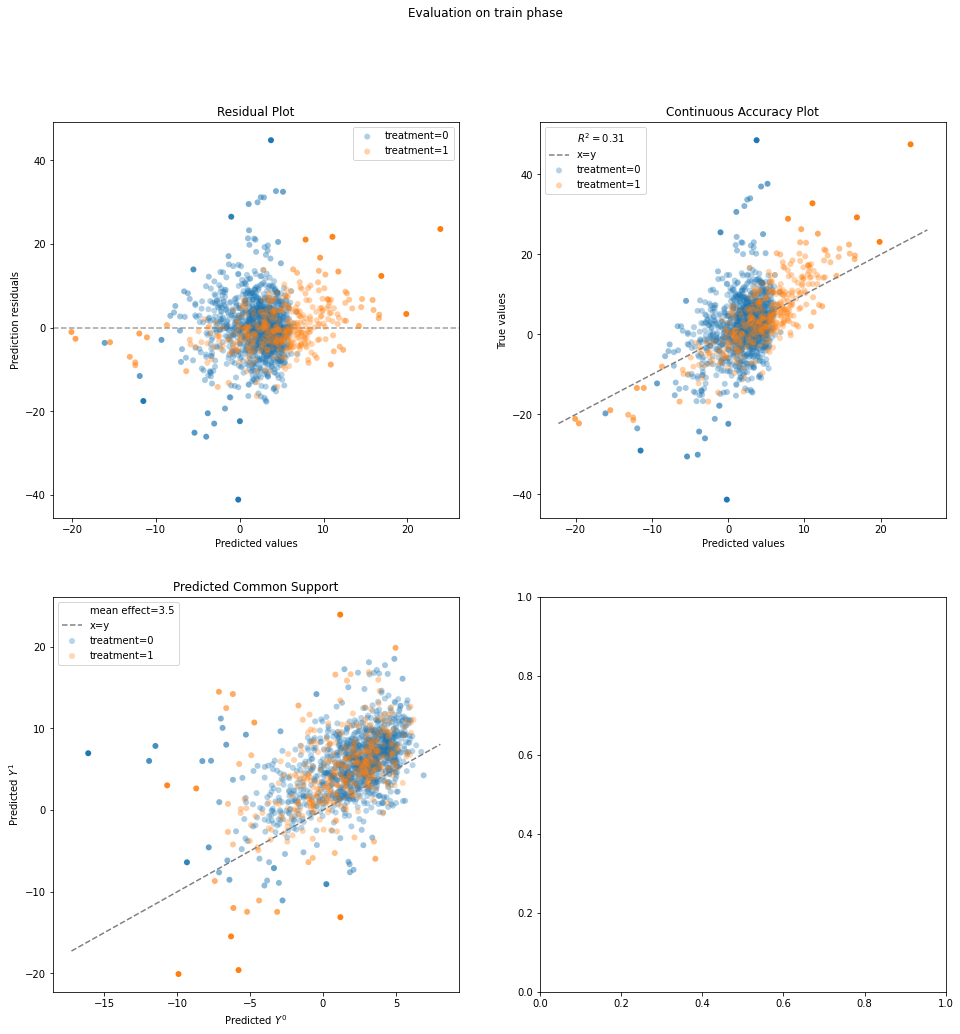

In [19]:
results = evaluate(std, data.X, data.a, data.y)
results.plot_all()

Results show the results for each treatment group separetly and also combined:

In [20]:
results.evaluated_metrics

,expvar,mae,mse,mdae,r2
model_strata,,,,,
actual,0.305271,4.748815,43.110264,3.725702,0.305271
0,0.134184,4.984365,48.001726,3.892460,0.134184
1,0.620207,4.069050,28.994209,3.366938,0.620207


#### Thorough evaluation

{'train': {'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>,
  'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>},
 'valid': {'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>,
  'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>}}

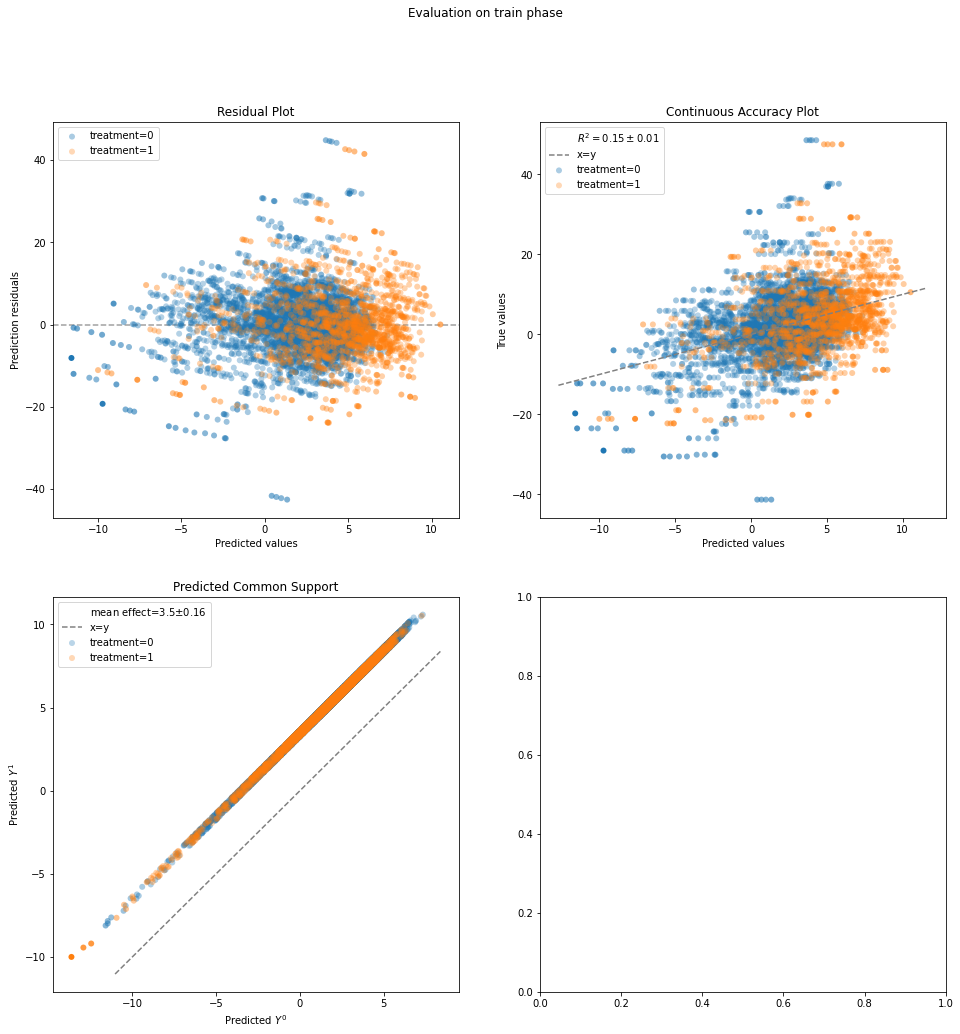

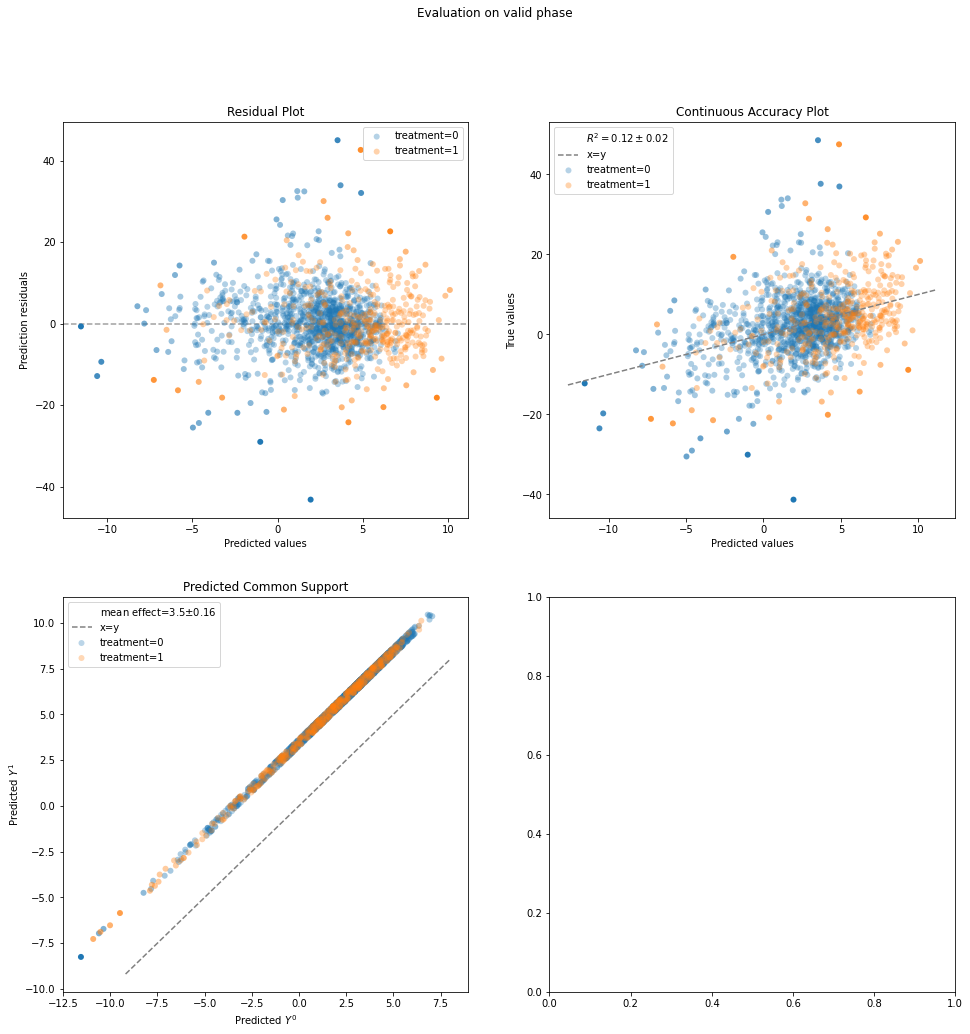

In [21]:
evaluation_results = evaluate(Standardization(LinearRegression()), data.X, data.a, data.y, cv="auto")
evaluation_results.plot_all()

In [22]:
results.evaluated_metrics

,expvar,mae,mse,mdae,r2
model_strata,,,,,
actual,0.305271,4.748815,43.110264,3.725702,0.305271
0,0.134184,4.984365,48.001726,3.892460,0.134184
1,0.620207,4.069050,28.994209,3.366938,0.620207


In [23]:
results.models

StratifiedStandardization(learner=LinearRegression())